# Import modules

In [88]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import os
from PIL import ImageOps
import PIL
import matplotlib.pyplot as plt
import cv2
import random

# Set Hyperparameter

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(777)
if device == "cuda":
    torch.cuda.manual_seed_all(777)
print(f"using {device}")

batch_size = 100
learning_rate = 1e-3
num_epoch = 2000

using cuda


# Load Data

In [90]:
def get_alphabet(root: str, batch_size: int):
    
    train_path = os.path.join(root, 'train')
    test_path = os.path.join(root, 'test')
    
    train1_rotation = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.RandomRotation(5)
                                 ]),
                                 target_transform=None)
    
    train2_default = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1)
                                     #, transforms.CenterCrop(26), transfroms.Resize(28)
                                 ]),
                                 target_transform=None)
    
    train3_crop = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.CenterCrop(26),
                                     transforms.Resize(28)
                                 ]),
                                 target_transform=None)
    
    train4_inv = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.RandomInvert()
                                 ]),
                                 target_transform=None)

    test2_kaggle = ImageFolder(root = "/home/r320ws/Desktop/wooseok/MNISTClassification/Dataset/alpha_small",
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Resize(28),
                                     transforms.Grayscale(1)
#                                      transforms.RandomInvert(1)
                                 ]),
                                 target_transform=None)
    
    alphabet_test = ImageFolder(root = test_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Grayscale(1)
                                 ]),
                                 target_transform=None)
    
    train_loader = DataLoader(train1_rotation,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True,
                              num_workers=8)

    test_loader = DataLoader(test2_kaggle,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False,
                             num_workers=8) 

    
    return (test2_kaggle, train_loader, test_loader)

In [91]:
data_path = '/home/r320ws/Desktop/wooseok/MNISTClassification/Dataset/processed_data/'
original_data, train_loader, test_loader = get_alphabet(data_path, batch_size)

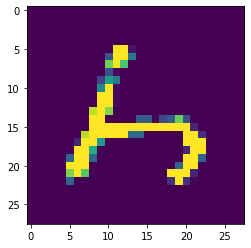

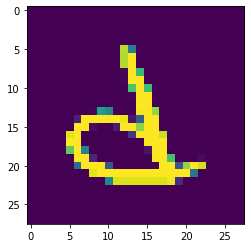

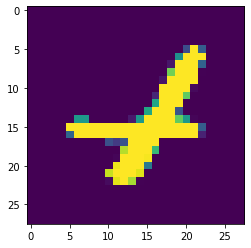

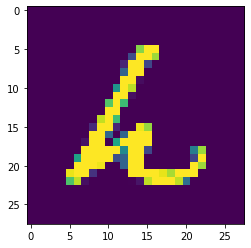

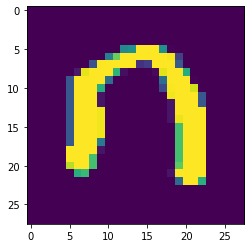

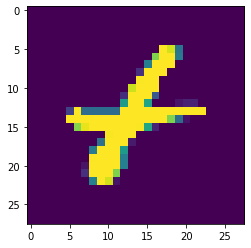

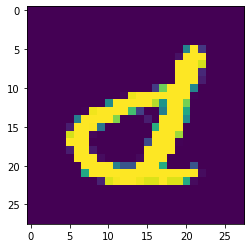

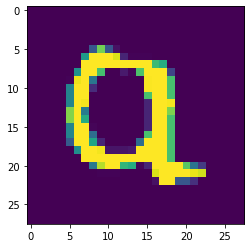

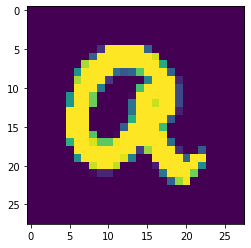

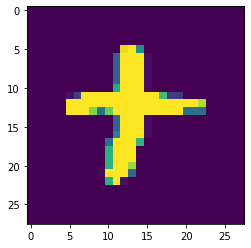

In [92]:
%matplotlib inline

def tensorToNumpy(tensor):
    c, w, h = tensor.shape
    
    img = np.zeros_like(tensor)
    img = img[0,:,:]
    img[:,:] = tensor[0,:,:]
    
    plt.figure()
    
    plt.imshow(img)

for i in random.choices(range(len(original_data)), k=10):
    image, target = original_data.__getitem__(i)
    tensorToNumpy(image)


# CNN Class

In [93]:
#### 
'''class CNN(nn.Module):  # train with rotated and adamw
    def __init__(self):
        a=32
        b=128
        c=512
        d=1024
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(          # 28x28      
            nn.Conv2d(a, b, 3, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(         #14x14
            nn.Conv2d(b, c, 3, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2, stride=2),
                         
            nn.Conv2d(c, d, 3, padding=1),
            nn.BatchNorm2d(d),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)            
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=d*4*4, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 26)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''

'''
## rotate, dropout04, optim_adam, kernel 5, out_feature = 512 ---> 99.56
## rotate, dropout04, optim_adam, kernel 3, out_feature = 512 ---> 99.48
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(c),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 26)
        )
        
#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''
    
    
## rotate, dropout04, optim_adam, kernel all 5, out_feature = 512 ---> 99.56
## rotate, dropout04, optim_adam, kernel 3, out_feature = 512 ---> 99.48
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 5, padding=2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 5, padding=2),
            nn.BatchNorm2d(c),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(512, 26, kernel_size=5, padding=2),
            nn.BatchNorm2d(26),
            nn.AdaptiveAvgPool2d(1),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        

        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out

#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
#     def forward(self, x):
#         out = self.layer1(x) 
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc_layer(out)
#         return out

    
    
    
    
## 



'''class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 26)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(512, 26, kernel_size=5, padding=2),
            nn.BatchNorm2d(26),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout(0.4)
        )
        
        
#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out
'''
    
'''   0.991
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=64
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(          # 28x28      
            nn.Conv2d(a, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(         #14x14
            nn.Conv2d(a, b, 3, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(inplace=True),  
            
            nn.Conv2d(b, b, kernel_size=3, padding=1),    #7x7
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 26)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''

'   0.991\nclass CNN(nn.Module):\n    def __init__(self):\n        a=32\n        b=64\n        c=512\n        \n        super(CNN, self).__init__()\n        self.layer1 = nn.Sequential(         # 28x28\n            nn.Conv2d(1, a, 3, padding=1),\n            nn.BatchNorm2d(a),\n            nn.ReLU(inplace=True),\n        )\n        self.layer2 = nn.Sequential(          # 28x28      \n            nn.Conv2d(a, a, 3, padding=1),\n            nn.BatchNorm2d(a),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(2,2)\n        )\n        self.layer3 = nn.Sequential(         #14x14\n            nn.Conv2d(a, b, 3, padding=1),\n            nn.BatchNorm2d(b),\n            nn.ReLU(inplace=True),  \n            \n            nn.Conv2d(b, b, kernel_size=3, padding=1),    #7x7\n            nn.BatchNorm2d(64),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2)\n        )\n        self.fc_layer = nn.Sequential(\n            nn.Linear(in_features=64*7*7, o

# Define model

In [7]:
model = CNN().to(device)

# train1_2_ pretrained
# model = torch.load("./weights/rotate_drpout04_adamoptim_kernel5_126ep_acc99.5619888305664.pth").to(device)


loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-1)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)


# Training

In [94]:
def test_acc(model, test_loader=test_loader):
    correct = 0
    total = 0
    model = model.eval()
    with torch.no_grad():
        for image, label in test_loader:
            x = image.to(device)
            y = label.to(device)

            output = model.forward(x)
            _, output_index = torch.max(output, 1)

            total += label.size(0)
            correct += (output_index == y ).sum().float()

        return f"{100.0*correct/total}"

In [9]:
max_accuracy =0.
from tqdm import tqdm

for i in range(1, num_epoch+1):
    model = model.train()
    for _, [image, label] in tqdm(enumerate(train_loader), total= len(train_loader)):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
    
    accuracy = float(test_acc(model))
    if (accuracy> max_accuracy and accuracy>99.5):
        max_accuracy = accuracy
        model_path = f"../weights/processed_Rotate_GAP_adam_reduceLR_all5kernel{i:03d}ep_acc{max_accuracy}.pth"
        torch.save(model, model_path)
    
    scheduler.step(accuracy)
    print(f"Epoch: {i}, Loss: {loss.item()}, LR: {scheduler.optimizer.state_dict()['param_groups'][0]['lr']}, Acc: {accuracy}, Best: {max_accuracy}")

100%|██████████| 221/221 [00:05<00:00, 41.11it/s]


Epoch: 1, Loss: 1.8361963033676147,            LR: 0.001, Acc: 68.30015563964844,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 42.06it/s]


Epoch: 2, Loss: 1.631909966468811,            LR: 0.001, Acc: 89.19273376464844,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.75it/s]


Epoch: 3, Loss: 1.3969725370407104,            LR: 0.001, Acc: 79.50120544433594,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.76it/s]


Epoch: 4, Loss: 1.436761736869812,            LR: 0.001, Acc: 92.32115173339844,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.37it/s]


Epoch: 5, Loss: 1.6288982629776,            LR: 0.001, Acc: 69.43775939941406,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.31it/s]


Epoch: 6, Loss: 1.3275028467178345,            LR: 0.001, Acc: 82.43273162841797,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 41.44it/s]


Epoch: 7, Loss: 1.4723248481750488,            LR: 0.001, Acc: 81.44825744628906,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.34it/s]


Epoch: 8, Loss: 1.4161685705184937,            LR: 0.001, Acc: 76.5696792602539,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.05it/s]


Epoch: 9, Loss: 1.3814175128936768,            LR: 0.001, Acc: 97.35287475585938,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.00it/s]


Epoch: 10, Loss: 1.3620193004608154,            LR: 0.001, Acc: 91.18354797363281,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.05it/s]


Epoch: 11, Loss: 1.6054415702819824,            LR: 0.001, Acc: 96.76219940185547,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 12, Loss: 1.277610421180725,            LR: 0.001, Acc: 98.79676055908203,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.89it/s]


Epoch: 13, Loss: 1.0457127094268799,            LR: 0.001, Acc: 94.61824798583984,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.06it/s]


Epoch: 14, Loss: 1.4414101839065552,            LR: 0.001, Acc: 99.27806091308594,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 15, Loss: 1.6102595329284668,            LR: 0.001, Acc: 98.94990539550781,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.82it/s]


Epoch: 16, Loss: 1.3646146059036255,            LR: 0.001, Acc: 89.12710571289062,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.97it/s]


Epoch: 17, Loss: 0.9582927823066711,            LR: 0.001, Acc: 93.9619369506836,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.99it/s]


Epoch: 18, Loss: 1.5879805088043213,            LR: 0.001, Acc: 99.36556243896484,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.14it/s]


Epoch: 19, Loss: 1.5236133337020874,            LR: 0.001, Acc: 98.9717788696289,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.83it/s]


Epoch: 20, Loss: 1.2595704793930054,            LR: 0.001, Acc: 98.77488708496094,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.40it/s]


Epoch: 21, Loss: 1.345032811164856,            LR: 0.001, Acc: 95.36206817626953,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 38.67it/s]


Epoch: 22, Loss: 1.4099618196487427,            LR: 0.001, Acc: 97.52789306640625,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.37it/s]


Epoch: 23, Loss: 1.3893558979034424,            LR: 0.001, Acc: 66.50623321533203,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 24, Loss: 1.6240997314453125,            LR: 0.001, Acc: 98.88426971435547,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.24it/s]


Epoch: 25, Loss: 1.4247772693634033,            LR: 0.001, Acc: 99.14679718017578,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.18it/s]


Epoch: 26, Loss: 1.505458116531372,            LR: 0.001, Acc: 99.2124252319336,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.81it/s]


Epoch: 27, Loss: 1.7789416313171387,            LR: 0.001, Acc: 99.38744354248047,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 38.45it/s]


Epoch: 28, Loss: 1.332167148590088,            LR: 0.001, Acc: 99.38744354248047,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.65it/s]


Epoch: 29, Loss: 1.5669946670532227,            LR: 0.001, Acc: 69.13148498535156,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.59it/s]


Epoch: 30, Loss: 1.3265079259872437,            LR: 0.001, Acc: 89.43338775634766,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.04it/s]


Epoch: 31, Loss: 1.2322088479995728,            LR: 0.001, Acc: 99.32181549072266,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 32, Loss: 1.3783049583435059,            LR: 0.001, Acc: 98.86239624023438,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.75it/s]


Epoch: 33, Loss: 1.4585332870483398,            LR: 0.001, Acc: 99.25617980957031,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.76it/s]


Epoch: 34, Loss: 0.8943618535995483,            LR: 0.001, Acc: 95.49332427978516,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 38.99it/s]


Epoch: 35, Loss: 1.2318921089172363,            LR: 0.001, Acc: 97.9654312133789,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.25it/s]


Epoch: 36, Loss: 1.256536602973938,            LR: 0.001, Acc: 98.05294036865234,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 39.08it/s]


Epoch: 37, Loss: 1.248378872871399,            LR: 0.001, Acc: 97.19973754882812,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.16it/s]


Epoch: 38, Loss: 1.0912233591079712,            LR: 0.0005, Acc: 98.7092514038086,           Best: 0.0


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 39, Loss: 1.3138258457183838,            LR: 0.0005, Acc: 99.73747253417969,           Best: 99.73747253417969


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 40, Loss: 1.4404798746109009,            LR: 0.0005, Acc: 99.34368896484375,           Best: 99.73747253417969


100%|██████████| 221/221 [00:05<00:00, 39.51it/s]


Epoch: 41, Loss: 1.2743388414382935,            LR: 0.0005, Acc: 99.73747253417969,           Best: 99.73747253417969


100%|██████████| 221/221 [00:05<00:00, 40.17it/s]


Epoch: 42, Loss: 1.3398021459579468,            LR: 0.0005, Acc: 99.01553344726562,           Best: 99.73747253417969


100%|██████████| 221/221 [00:05<00:00, 38.02it/s]


Epoch: 43, Loss: 1.4716721773147583,            LR: 0.0005, Acc: 99.82498168945312,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.58it/s]


Epoch: 44, Loss: 1.2831933498382568,            LR: 0.0005, Acc: 99.64997100830078,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 45, Loss: 1.1855213642120361,            LR: 0.0005, Acc: 99.82498168945312,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 38.60it/s]


Epoch: 46, Loss: 1.3753029108047485,            LR: 0.0005, Acc: 99.34368896484375,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.78it/s]


Epoch: 47, Loss: 1.3413914442062378,            LR: 0.0005, Acc: 99.7155990600586,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.55it/s]


Epoch: 48, Loss: 1.2722656726837158,            LR: 0.0005, Acc: 99.75935363769531,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.84it/s]


Epoch: 49, Loss: 1.2086386680603027,            LR: 0.0005, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.02it/s]


Epoch: 50, Loss: 1.17558753490448,            LR: 0.0005, Acc: 99.38744354248047,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.98it/s]


Epoch: 51, Loss: 1.666445016860962,            LR: 0.0005, Acc: 99.54058074951172,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.67it/s]


Epoch: 52, Loss: 1.4427447319030762,            LR: 0.0005, Acc: 99.58433532714844,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 38.70it/s]


Epoch: 53, Loss: 1.3066437244415283,            LR: 0.0005, Acc: 99.69371795654297,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.35it/s]


Epoch: 54, Loss: 1.2757285833358765,            LR: 0.00025, Acc: 99.75935363769531,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 38.53it/s]


Epoch: 55, Loss: 1.6317459344863892,            LR: 0.00025, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.80it/s]


Epoch: 56, Loss: 1.3080157041549683,            LR: 0.00025, Acc: 99.80310821533203,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 57, Loss: 1.3489882946014404,            LR: 0.00025, Acc: 99.75935363769531,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 58, Loss: 1.179916501045227,            LR: 0.00025, Acc: 99.82498168945312,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.48it/s]


Epoch: 59, Loss: 1.5349969863891602,            LR: 0.00025, Acc: 99.67184448242188,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.26it/s]


Epoch: 60, Loss: 1.4353888034820557,            LR: 0.00025, Acc: 99.7155990600586,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.65it/s]


Epoch: 61, Loss: 1.4044418334960938,            LR: 0.00025, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.06it/s]


Epoch: 62, Loss: 1.2409517765045166,            LR: 0.00025, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.92it/s]


Epoch: 63, Loss: 1.3059500455856323,            LR: 0.00025, Acc: 99.73747253417969,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.75it/s]


Epoch: 64, Loss: 0.9788358807563782,            LR: 0.00025, Acc: 99.64997100830078,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 40.10it/s]


Epoch: 65, Loss: 1.1098377704620361,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.82498168945312


100%|██████████| 221/221 [00:05<00:00, 39.71it/s]


Epoch: 66, Loss: 0.916647732257843,            LR: 0.000125, Acc: 99.84686279296875,           Best: 99.84686279296875


100%|██████████| 221/221 [00:05<00:00, 39.62it/s]


Epoch: 67, Loss: 1.401816964149475,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.84686279296875


100%|██████████| 221/221 [00:05<00:00, 39.45it/s]


Epoch: 68, Loss: 1.4364513158798218,            LR: 0.000125, Acc: 99.7155990600586,           Best: 99.84686279296875


100%|██████████| 221/221 [00:05<00:00, 40.01it/s]


Epoch: 69, Loss: 1.500477910041809,            LR: 0.000125, Acc: 99.75935363769531,           Best: 99.84686279296875


100%|██████████| 221/221 [00:05<00:00, 40.21it/s]


Epoch: 70, Loss: 1.3711978197097778,            LR: 0.000125, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.85it/s]


Epoch: 71, Loss: 1.2403427362442017,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.68it/s]


Epoch: 72, Loss: 1.4698001146316528,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.77it/s]


Epoch: 73, Loss: 1.3378371000289917,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.10it/s]


Epoch: 74, Loss: 1.4031904935836792,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.30it/s]


Epoch: 75, Loss: 1.3690872192382812,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.88it/s]


Epoch: 76, Loss: 1.2065446376800537,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.53it/s]


Epoch: 77, Loss: 0.9794563055038452,            LR: 0.000125, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.73it/s]


Epoch: 78, Loss: 1.1453427076339722,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.06it/s]


Epoch: 79, Loss: 1.3383363485336304,            LR: 0.000125, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 80, Loss: 1.0106043815612793,            LR: 0.000125, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 81, Loss: 1.3045498132705688,            LR: 6.25e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.74it/s]


Epoch: 82, Loss: 1.2071900367736816,            LR: 6.25e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.75it/s]


Epoch: 83, Loss: 1.4361441135406494,            LR: 6.25e-05, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.39it/s]


Epoch: 84, Loss: 1.1411715745925903,            LR: 6.25e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.26it/s]


Epoch: 85, Loss: 1.2716368436813354,            LR: 6.25e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 86, Loss: 1.3053655624389648,            LR: 6.25e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.74it/s]


Epoch: 87, Loss: 1.2082467079162598,            LR: 6.25e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.65it/s]


Epoch: 88, Loss: 1.3394335508346558,            LR: 6.25e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.90it/s]


Epoch: 89, Loss: 1.304989218711853,            LR: 6.25e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.54it/s]


Epoch: 90, Loss: 1.2393909692764282,            LR: 6.25e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.78it/s]


Epoch: 91, Loss: 1.043683648109436,            LR: 6.25e-05, Acc: 99.73747253417969,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 92, Loss: 1.403069019317627,            LR: 3.125e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.45it/s]


Epoch: 93, Loss: 1.4995815753936768,            LR: 3.125e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.70it/s]


Epoch: 94, Loss: 1.0774600505828857,            LR: 3.125e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.39it/s]


Epoch: 95, Loss: 1.4018776416778564,            LR: 3.125e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.82it/s]


Epoch: 96, Loss: 1.6643245220184326,            LR: 3.125e-05, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.46it/s]


Epoch: 97, Loss: 1.0759962797164917,            LR: 3.125e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.77it/s]


Epoch: 98, Loss: 1.273288607597351,            LR: 3.125e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.82it/s]


Epoch: 99, Loss: 1.6632059812545776,            LR: 3.125e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.98it/s]


Epoch: 100, Loss: 1.4343171119689941,            LR: 3.125e-05, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.36it/s]


Epoch: 101, Loss: 1.4371862411499023,            LR: 3.125e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.93it/s]


Epoch: 102, Loss: 1.3059576749801636,            LR: 3.125e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 103, Loss: 1.3690906763076782,            LR: 1.5625e-05, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.33it/s]


Epoch: 104, Loss: 1.2393406629562378,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.79it/s]


Epoch: 105, Loss: 1.3376792669296265,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.64it/s]


Epoch: 106, Loss: 1.0762205123901367,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.65it/s]


Epoch: 107, Loss: 1.533218502998352,            LR: 1.5625e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.28it/s]


Epoch: 108, Loss: 1.3371024131774902,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.80it/s]


Epoch: 109, Loss: 1.3050776720046997,            LR: 1.5625e-05, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.73it/s]


Epoch: 110, Loss: 1.0763808488845825,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 111, Loss: 1.5338490009307861,            LR: 1.5625e-05, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.87it/s]


Epoch: 112, Loss: 1.2423371076583862,            LR: 1.5625e-05, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.79it/s]


Epoch: 113, Loss: 1.2443758249282837,            LR: 1.5625e-05, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.46it/s]


Epoch: 114, Loss: 1.1080999374389648,            LR: 7.8125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.31it/s]


Epoch: 115, Loss: 1.5331419706344604,            LR: 7.8125e-06, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 116, Loss: 1.4075199365615845,            LR: 7.8125e-06, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.37it/s]


Epoch: 117, Loss: 1.435377836227417,            LR: 7.8125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.97it/s]


Epoch: 118, Loss: 1.3730772733688354,            LR: 7.8125e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 119, Loss: 1.336844801902771,            LR: 7.8125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.57it/s]


Epoch: 120, Loss: 1.305680274963379,            LR: 7.8125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.59it/s]


Epoch: 121, Loss: 1.1758729219436646,            LR: 7.8125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.97it/s]


Epoch: 122, Loss: 1.2407984733581543,            LR: 7.8125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.21it/s]


Epoch: 123, Loss: 1.2394590377807617,            LR: 7.8125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.66it/s]


Epoch: 124, Loss: 1.239230990409851,            LR: 7.8125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.80it/s]


Epoch: 125, Loss: 1.565779209136963,            LR: 3.90625e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.87it/s]


Epoch: 126, Loss: 1.2066259384155273,            LR: 3.90625e-06, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.14it/s]


Epoch: 127, Loss: 0.9465964436531067,            LR: 3.90625e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.74it/s]


Epoch: 128, Loss: 1.1105057001113892,            LR: 3.90625e-06, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.78it/s]


Epoch: 129, Loss: 1.4672367572784424,            LR: 3.90625e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.31it/s]


Epoch: 130, Loss: 1.1743745803833008,            LR: 3.90625e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.10it/s]


Epoch: 131, Loss: 1.4667853116989136,            LR: 3.90625e-06, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 132, Loss: 1.2718087434768677,            LR: 3.90625e-06, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.16it/s]


Epoch: 133, Loss: 1.6646888256072998,            LR: 3.90625e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.58it/s]


Epoch: 134, Loss: 1.240411639213562,            LR: 3.90625e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.77it/s]


Epoch: 135, Loss: 1.3362599611282349,            LR: 3.90625e-06, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.81it/s]


Epoch: 136, Loss: 1.7337861061096191,            LR: 1.953125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.69it/s]


Epoch: 137, Loss: 1.2726056575775146,            LR: 1.953125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 138, Loss: 1.213106632232666,            LR: 1.953125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.48it/s]


Epoch: 139, Loss: 1.4711596965789795,            LR: 1.953125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.66it/s]


Epoch: 140, Loss: 1.3699829578399658,            LR: 1.953125e-06, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 141, Loss: 1.4031589031219482,            LR: 1.953125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.61it/s]


Epoch: 142, Loss: 1.211226463317871,            LR: 1.953125e-06, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.60it/s]


Epoch: 143, Loss: 1.3389112949371338,            LR: 1.953125e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.39it/s]


Epoch: 144, Loss: 1.4049144983291626,            LR: 1.953125e-06, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.92it/s]


Epoch: 145, Loss: 1.5970945358276367,            LR: 1.953125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.09it/s]


Epoch: 146, Loss: 1.435700535774231,            LR: 1.953125e-06, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.30it/s]


Epoch: 147, Loss: 1.2725263833999634,            LR: 9.765625e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 148, Loss: 1.3038406372070312,            LR: 9.765625e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.68it/s]


Epoch: 149, Loss: 1.3721812963485718,            LR: 9.765625e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.70it/s]


Epoch: 150, Loss: 1.2726155519485474,            LR: 9.765625e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.69it/s]


Epoch: 151, Loss: 1.3713077306747437,            LR: 9.765625e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.48it/s]


Epoch: 152, Loss: 1.206011176109314,            LR: 9.765625e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.77it/s]


Epoch: 153, Loss: 1.1767908334732056,            LR: 9.765625e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.31it/s]


Epoch: 154, Loss: 1.4133939743041992,            LR: 9.765625e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.72it/s]


Epoch: 155, Loss: 1.2732083797454834,            LR: 9.765625e-07, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.19it/s]


Epoch: 156, Loss: 1.4400025606155396,            LR: 9.765625e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.73it/s]


Epoch: 157, Loss: 1.5003862380981445,            LR: 9.765625e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.19it/s]


Epoch: 158, Loss: 1.0760694742202759,            LR: 4.8828125e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.35it/s]


Epoch: 159, Loss: 0.9473173022270203,            LR: 4.8828125e-07, Acc: 99.73747253417969,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.01it/s]


Epoch: 160, Loss: 1.2398929595947266,            LR: 4.8828125e-07, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.38it/s]


Epoch: 161, Loss: 1.5969740152359009,            LR: 4.8828125e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.63it/s]


Epoch: 162, Loss: 1.467729926109314,            LR: 4.8828125e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.22it/s]


Epoch: 163, Loss: 1.5660247802734375,            LR: 4.8828125e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.88it/s]


Epoch: 164, Loss: 1.403212070465088,            LR: 4.8828125e-07, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.80it/s]


Epoch: 165, Loss: 1.4031180143356323,            LR: 4.8828125e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.57it/s]


Epoch: 166, Loss: 1.1415935754776,            LR: 4.8828125e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.02it/s]


Epoch: 167, Loss: 1.5650620460510254,            LR: 4.8828125e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 168, Loss: 1.1102237701416016,            LR: 4.8828125e-07, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.15it/s]


Epoch: 169, Loss: 1.3695331811904907,            LR: 2.44140625e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.31it/s]


Epoch: 170, Loss: 1.3046202659606934,            LR: 2.44140625e-07, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.49it/s]


Epoch: 171, Loss: 1.3711144924163818,            LR: 2.44140625e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.56it/s]


Epoch: 172, Loss: 1.4035879373550415,            LR: 2.44140625e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 173, Loss: 1.7274061441421509,            LR: 2.44140625e-07, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.65it/s]


Epoch: 174, Loss: 1.2099517583847046,            LR: 2.44140625e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.38it/s]


Epoch: 175, Loss: 1.17449152469635,            LR: 2.44140625e-07, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 176, Loss: 1.4021801948547363,            LR: 2.44140625e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.07it/s]


Epoch: 177, Loss: 1.0433655977249146,            LR: 2.44140625e-07, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.95it/s]


Epoch: 178, Loss: 1.4357824325561523,            LR: 2.44140625e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.17it/s]


Epoch: 179, Loss: 1.3713322877883911,            LR: 2.44140625e-07, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 180, Loss: 1.239789605140686,            LR: 1.220703125e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.69it/s]


Epoch: 181, Loss: 1.4025359153747559,            LR: 1.220703125e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.06it/s]


Epoch: 182, Loss: 1.3362936973571777,            LR: 1.220703125e-07, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.24it/s]


Epoch: 183, Loss: 1.3038100004196167,            LR: 1.220703125e-07, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.61it/s]


Epoch: 184, Loss: 1.2710872888565063,            LR: 1.220703125e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.60it/s]


Epoch: 185, Loss: 1.2404223680496216,            LR: 1.220703125e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.57it/s]


Epoch: 186, Loss: 1.468308448791504,            LR: 1.220703125e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.64it/s]


Epoch: 187, Loss: 1.304423213005066,            LR: 1.220703125e-07, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.67it/s]


Epoch: 188, Loss: 1.142198920249939,            LR: 1.220703125e-07, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.82it/s]


Epoch: 189, Loss: 1.0120426416397095,            LR: 1.220703125e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.10it/s]


Epoch: 190, Loss: 1.2058584690093994,            LR: 1.220703125e-07, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.89it/s]


Epoch: 191, Loss: 1.532110333442688,            LR: 6.103515625e-08, Acc: 99.73747253417969,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.13it/s]


Epoch: 192, Loss: 1.1085096597671509,            LR: 6.103515625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.60it/s]


Epoch: 193, Loss: 1.3367223739624023,            LR: 6.103515625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.81it/s]


Epoch: 194, Loss: 1.2419145107269287,            LR: 6.103515625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.53it/s]


Epoch: 195, Loss: 1.2079485654830933,            LR: 6.103515625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.91it/s]


Epoch: 196, Loss: 1.108829140663147,            LR: 6.103515625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 197, Loss: 1.1742026805877686,            LR: 6.103515625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.98it/s]


Epoch: 198, Loss: 1.372467041015625,            LR: 6.103515625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.17it/s]


Epoch: 199, Loss: 1.0801315307617188,            LR: 6.103515625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.00it/s]


Epoch: 200, Loss: 1.239734172821045,            LR: 6.103515625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.73it/s]


Epoch: 201, Loss: 1.1762601137161255,            LR: 6.103515625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.68it/s]


Epoch: 202, Loss: 1.1092654466629028,            LR: 3.0517578125e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.41it/s]


Epoch: 203, Loss: 0.9792343974113464,            LR: 3.0517578125e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.54it/s]


Epoch: 204, Loss: 1.144909381866455,            LR: 3.0517578125e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.00it/s]


Epoch: 205, Loss: 1.4039180278778076,            LR: 3.0517578125e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.98it/s]


Epoch: 206, Loss: 1.24114191532135,            LR: 3.0517578125e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.68it/s]


Epoch: 207, Loss: 1.141395092010498,            LR: 3.0517578125e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.89it/s]


Epoch: 208, Loss: 1.5330805778503418,            LR: 3.0517578125e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 209, Loss: 1.1741979122161865,            LR: 3.0517578125e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.74it/s]


Epoch: 210, Loss: 1.3693482875823975,            LR: 3.0517578125e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.41it/s]


Epoch: 211, Loss: 1.1410428285598755,            LR: 3.0517578125e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 212, Loss: 1.3405539989471436,            LR: 3.0517578125e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.29it/s]


Epoch: 213, Loss: 1.3376965522766113,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.64it/s]


Epoch: 214, Loss: 1.3066118955612183,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.99it/s]


Epoch: 215, Loss: 1.566291093826294,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.37it/s]


Epoch: 216, Loss: 1.2093101739883423,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.34it/s]


Epoch: 217, Loss: 1.3397948741912842,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.93it/s]


Epoch: 218, Loss: 1.2067251205444336,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.44it/s]


Epoch: 219, Loss: 1.0760900974273682,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.69it/s]


Epoch: 220, Loss: 1.3700906038284302,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.92it/s]


Epoch: 221, Loss: 1.3059391975402832,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.25it/s]


Epoch: 222, Loss: 1.207266926765442,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.26it/s]


Epoch: 223, Loss: 1.1433563232421875,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.33it/s]


Epoch: 224, Loss: 1.3034729957580566,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.27it/s]


Epoch: 225, Loss: 1.369505763053894,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.51it/s]


Epoch: 226, Loss: 1.2733534574508667,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.85it/s]


Epoch: 227, Loss: 1.2730392217636108,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.56it/s]


Epoch: 228, Loss: 1.5670247077941895,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.38it/s]


Epoch: 229, Loss: 1.3386729955673218,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.26it/s]


Epoch: 230, Loss: 1.305092453956604,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.19it/s]


Epoch: 231, Loss: 1.3365205526351929,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.51it/s]


Epoch: 232, Loss: 1.3373589515686035,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.94it/s]


Epoch: 233, Loss: 1.6297764778137207,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.89it/s]


Epoch: 234, Loss: 1.5971112251281738,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.26it/s]


Epoch: 235, Loss: 1.2392897605895996,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 236, Loss: 1.4391989707946777,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.08it/s]


Epoch: 237, Loss: 1.5646154880523682,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.04it/s]


Epoch: 238, Loss: 1.3699264526367188,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.74it/s]


Epoch: 239, Loss: 1.2398127317428589,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.74it/s]


Epoch: 240, Loss: 1.5330653190612793,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.46it/s]


Epoch: 241, Loss: 1.0756279230117798,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 242, Loss: 1.1430449485778809,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.79it/s]


Epoch: 243, Loss: 1.1744275093078613,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.51it/s]


Epoch: 244, Loss: 1.0126937627792358,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.22it/s]


Epoch: 245, Loss: 0.9777636528015137,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.28it/s]


Epoch: 246, Loss: 1.1087839603424072,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.13it/s]


Epoch: 247, Loss: 1.1439162492752075,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.19it/s]


Epoch: 248, Loss: 1.339237928390503,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.08it/s]


Epoch: 249, Loss: 1.1094179153442383,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.88it/s]


Epoch: 250, Loss: 1.4022507667541504,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.89it/s]


Epoch: 251, Loss: 1.3044407367706299,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.98it/s]


Epoch: 252, Loss: 1.4673151969909668,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.49it/s]


Epoch: 253, Loss: 1.4352271556854248,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.13it/s]


Epoch: 254, Loss: 1.2398390769958496,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.93it/s]


Epoch: 255, Loss: 1.2737903594970703,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 256, Loss: 1.208818793296814,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.42it/s]


Epoch: 257, Loss: 1.5971485376358032,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.13it/s]


Epoch: 258, Loss: 1.304762840270996,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.04it/s]


Epoch: 259, Loss: 1.0444165468215942,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.24it/s]


Epoch: 260, Loss: 1.1409311294555664,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.36it/s]


Epoch: 261, Loss: 1.2065751552581787,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.82it/s]


Epoch: 262, Loss: 1.4043186902999878,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.01it/s]


Epoch: 263, Loss: 1.5352765321731567,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.84it/s]


Epoch: 264, Loss: 1.3706574440002441,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.46it/s]


Epoch: 265, Loss: 1.5647337436676025,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.73it/s]


Epoch: 266, Loss: 1.5003982782363892,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 267, Loss: 1.4687657356262207,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.18it/s]


Epoch: 268, Loss: 1.4341635704040527,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.92it/s]


Epoch: 269, Loss: 1.305992603302002,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.66it/s]


Epoch: 270, Loss: 1.0444755554199219,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.00it/s]


Epoch: 271, Loss: 1.0776032209396362,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.22it/s]


Epoch: 272, Loss: 1.500544786453247,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.64it/s]


Epoch: 273, Loss: 0.9142747521400452,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.28it/s]


Epoch: 274, Loss: 1.140987515449524,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 275, Loss: 1.6632018089294434,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.51it/s]


Epoch: 276, Loss: 1.435203194618225,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.54it/s]


Epoch: 277, Loss: 1.238366961479187,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.47it/s]


Epoch: 278, Loss: 1.4024231433868408,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.58it/s]


Epoch: 279, Loss: 1.271898627281189,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.82it/s]


Epoch: 280, Loss: 1.3052287101745605,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.21it/s]


Epoch: 281, Loss: 1.5027281045913696,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.86it/s]


Epoch: 282, Loss: 1.1124238967895508,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.74it/s]


Epoch: 283, Loss: 1.4670683145523071,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.07it/s]


Epoch: 284, Loss: 1.3374340534210205,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.97it/s]


Epoch: 285, Loss: 1.6295504570007324,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.33it/s]


Epoch: 286, Loss: 1.3370851278305054,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.47it/s]


Epoch: 287, Loss: 1.4685460329055786,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.47it/s]


Epoch: 288, Loss: 1.2072710990905762,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.08it/s]


Epoch: 289, Loss: 1.1104172468185425,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.22it/s]


Epoch: 290, Loss: 1.3702757358551025,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.87it/s]


Epoch: 291, Loss: 1.4017894268035889,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.59it/s]


Epoch: 292, Loss: 1.3384661674499512,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.57it/s]


Epoch: 293, Loss: 1.1754738092422485,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.90it/s]


Epoch: 294, Loss: 1.5985103845596313,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.16it/s]


Epoch: 295, Loss: 1.3044259548187256,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.13it/s]


Epoch: 296, Loss: 1.7281657457351685,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.53it/s]


Epoch: 297, Loss: 1.3373569250106812,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.70it/s]


Epoch: 298, Loss: 1.2074596881866455,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.39it/s]


Epoch: 299, Loss: 1.4997413158416748,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.58it/s]


Epoch: 300, Loss: 1.4354333877563477,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.65it/s]


Epoch: 301, Loss: 1.304198145866394,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.07it/s]


Epoch: 302, Loss: 1.3362318277359009,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.77it/s]


Epoch: 303, Loss: 1.1747359037399292,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.70it/s]


Epoch: 304, Loss: 1.4377480745315552,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.23it/s]


Epoch: 305, Loss: 1.0781692266464233,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.33it/s]


Epoch: 306, Loss: 1.4034254550933838,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.20it/s]


Epoch: 307, Loss: 1.3370929956436157,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.58it/s]


Epoch: 308, Loss: 1.401732325553894,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.95it/s]


Epoch: 309, Loss: 1.0119495391845703,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.65it/s]


Epoch: 310, Loss: 1.2073988914489746,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.66it/s]


Epoch: 311, Loss: 1.33738112449646,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.91it/s]


Epoch: 312, Loss: 1.5331612825393677,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.63it/s]


Epoch: 313, Loss: 1.1115214824676514,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.85it/s]


Epoch: 314, Loss: 1.3040539026260376,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.20it/s]


Epoch: 315, Loss: 1.2394589185714722,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.85it/s]


Epoch: 316, Loss: 1.2424222230911255,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 317, Loss: 1.336309552192688,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.07it/s]


Epoch: 318, Loss: 1.3709418773651123,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.88it/s]


Epoch: 319, Loss: 1.4015936851501465,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.88it/s]


Epoch: 320, Loss: 1.369490385055542,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.48it/s]


Epoch: 321, Loss: 1.3047508001327515,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 322, Loss: 1.1738852262496948,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.71it/s]


Epoch: 323, Loss: 1.341590166091919,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.62it/s]


Epoch: 324, Loss: 1.0119297504425049,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.95it/s]


Epoch: 325, Loss: 1.3051241636276245,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.75it/s]


Epoch: 326, Loss: 1.0452234745025635,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.39it/s]


Epoch: 327, Loss: 1.4037961959838867,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.90it/s]


Epoch: 328, Loss: 1.2385936975479126,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.62it/s]


Epoch: 329, Loss: 1.2397361993789673,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.46it/s]


Epoch: 330, Loss: 1.174582600593567,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.66it/s]


Epoch: 331, Loss: 1.2390285730361938,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.33it/s]


Epoch: 332, Loss: 1.1425423622131348,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.59it/s]


Epoch: 333, Loss: 1.2064687013626099,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.83it/s]


Epoch: 334, Loss: 1.2391536235809326,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.02it/s]


Epoch: 335, Loss: 1.3045823574066162,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.69it/s]


Epoch: 336, Loss: 1.206414818763733,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.26it/s]


Epoch: 337, Loss: 1.4342089891433716,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.95it/s]


Epoch: 338, Loss: 1.2710919380187988,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 339, Loss: 1.3709498643875122,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.24it/s]


Epoch: 340, Loss: 1.0766923427581787,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.45it/s]


Epoch: 341, Loss: 1.792585015296936,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.22it/s]


Epoch: 342, Loss: 1.2108545303344727,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.16it/s]


Epoch: 343, Loss: 1.4347683191299438,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.94it/s]


Epoch: 344, Loss: 1.4348300695419312,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.42it/s]


Epoch: 345, Loss: 1.1409103870391846,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.13it/s]


Epoch: 346, Loss: 1.5000004768371582,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.22it/s]


Epoch: 347, Loss: 1.4683254957199097,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.42it/s]


Epoch: 348, Loss: 1.408981204032898,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 349, Loss: 1.4014410972595215,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.21it/s]


Epoch: 350, Loss: 1.2392284870147705,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.87it/s]


Epoch: 351, Loss: 1.239008903503418,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 352, Loss: 1.3057353496551514,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.14it/s]


Epoch: 353, Loss: 1.047441840171814,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.85it/s]


Epoch: 354, Loss: 1.1087926626205444,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.93it/s]


Epoch: 355, Loss: 1.2710713148117065,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.26it/s]


Epoch: 356, Loss: 1.4358772039413452,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.07it/s]


Epoch: 357, Loss: 1.2396843433380127,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.90it/s]


Epoch: 358, Loss: 1.1748435497283936,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.77it/s]


Epoch: 359, Loss: 1.2061660289764404,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.31it/s]


Epoch: 360, Loss: 1.371232032775879,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.52it/s]


Epoch: 361, Loss: 1.4025530815124512,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.53it/s]


Epoch: 362, Loss: 1.1142628192901611,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.07it/s]


Epoch: 363, Loss: 1.206817865371704,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.63it/s]


Epoch: 364, Loss: 1.436309814453125,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.58it/s]


Epoch: 365, Loss: 1.2715370655059814,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.79it/s]


Epoch: 366, Loss: 1.3370682001113892,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 367, Loss: 1.4042439460754395,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.57it/s]


Epoch: 368, Loss: 1.141292691230774,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.63it/s]


Epoch: 369, Loss: 0.9466235637664795,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.73it/s]


Epoch: 370, Loss: 1.1749759912490845,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.37it/s]


Epoch: 371, Loss: 1.3427258729934692,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.68it/s]


Epoch: 372, Loss: 1.173661231994629,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.54it/s]


Epoch: 373, Loss: 1.1734927892684937,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.64it/s]


Epoch: 374, Loss: 1.1097421646118164,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 375, Loss: 1.3048139810562134,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.78it/s]


Epoch: 376, Loss: 1.011504054069519,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.08it/s]


Epoch: 377, Loss: 1.1747382879257202,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.26it/s]


Epoch: 378, Loss: 1.2063517570495605,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 379, Loss: 1.2066360712051392,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.77it/s]


Epoch: 380, Loss: 1.2063404321670532,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.25it/s]


Epoch: 381, Loss: 1.2726309299468994,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.88it/s]


Epoch: 382, Loss: 1.3702245950698853,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.42it/s]


Epoch: 383, Loss: 1.140974521636963,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.38it/s]


Epoch: 384, Loss: 1.1419893503189087,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.68it/s]


Epoch: 385, Loss: 0.9169937372207642,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.66it/s]


Epoch: 386, Loss: 1.0434975624084473,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.53it/s]


Epoch: 387, Loss: 1.3416144847869873,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.97it/s]


Epoch: 388, Loss: 1.4030879735946655,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.95it/s]


Epoch: 389, Loss: 1.2716456651687622,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.25it/s]


Epoch: 390, Loss: 1.3377928733825684,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.42it/s]


Epoch: 391, Loss: 1.0106356143951416,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.31it/s]


Epoch: 392, Loss: 1.239018440246582,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 393, Loss: 1.3048988580703735,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 394, Loss: 1.0110859870910645,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.41it/s]


Epoch: 395, Loss: 1.5649824142456055,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.56it/s]


Epoch: 396, Loss: 1.4358360767364502,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.93it/s]


Epoch: 397, Loss: 1.7274665832519531,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.06it/s]


Epoch: 398, Loss: 1.3369038105010986,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.75it/s]


Epoch: 399, Loss: 1.4691801071166992,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.97it/s]


Epoch: 400, Loss: 1.531768798828125,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.15it/s]


Epoch: 401, Loss: 1.434918999671936,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.16it/s]


Epoch: 402, Loss: 1.599267601966858,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.78it/s]


Epoch: 403, Loss: 1.0762041807174683,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.49it/s]


Epoch: 404, Loss: 1.0779597759246826,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.49it/s]


Epoch: 405, Loss: 0.8150160908699036,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.48it/s]


Epoch: 406, Loss: 1.2063350677490234,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.84it/s]


Epoch: 407, Loss: 1.2100882530212402,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.53it/s]


Epoch: 408, Loss: 1.2088217735290527,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 409, Loss: 1.0147559642791748,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.34it/s]


Epoch: 410, Loss: 1.2408971786499023,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.90it/s]


Epoch: 411, Loss: 1.338020920753479,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.30it/s]


Epoch: 412, Loss: 1.4045686721801758,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.75it/s]


Epoch: 413, Loss: 1.1849311590194702,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.39it/s]


Epoch: 414, Loss: 1.5982166528701782,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.37it/s]


Epoch: 415, Loss: 1.3067001104354858,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.36it/s]


Epoch: 416, Loss: 1.239895224571228,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.25it/s]


Epoch: 417, Loss: 1.3037216663360596,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.04it/s]


Epoch: 418, Loss: 1.434450387954712,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.61it/s]


Epoch: 419, Loss: 1.3732458353042603,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.62it/s]


Epoch: 420, Loss: 1.2064216136932373,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.55it/s]


Epoch: 421, Loss: 1.1432586908340454,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.39it/s]


Epoch: 422, Loss: 1.5659871101379395,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.12it/s]


Epoch: 423, Loss: 1.3723573684692383,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 424, Loss: 1.4991919994354248,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.12it/s]


Epoch: 425, Loss: 1.206527829170227,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.19it/s]


Epoch: 426, Loss: 1.3714121580123901,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 427, Loss: 1.3688958883285522,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.69it/s]


Epoch: 428, Loss: 1.240810751914978,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.87it/s]


Epoch: 429, Loss: 1.3377324342727661,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.07it/s]


Epoch: 430, Loss: 1.5000107288360596,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.25it/s]


Epoch: 431, Loss: 1.046072244644165,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.04it/s]


Epoch: 432, Loss: 1.2065401077270508,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.01it/s]


Epoch: 433, Loss: 1.4680206775665283,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.72it/s]


Epoch: 434, Loss: 1.3699243068695068,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.79it/s]


Epoch: 435, Loss: 1.468461513519287,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.25it/s]


Epoch: 436, Loss: 1.5343021154403687,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.23it/s]


Epoch: 437, Loss: 1.2711633443832397,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.72it/s]


Epoch: 438, Loss: 1.4361003637313843,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.35it/s]


Epoch: 439, Loss: 1.3382891416549683,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.21it/s]


Epoch: 440, Loss: 1.3078259229660034,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.59it/s]


Epoch: 441, Loss: 1.4669876098632812,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.49it/s]


Epoch: 442, Loss: 1.4666632413864136,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.85it/s]


Epoch: 443, Loss: 1.4345452785491943,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.89it/s]


Epoch: 444, Loss: 0.978911280632019,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.03it/s]


Epoch: 445, Loss: 1.6317694187164307,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.45it/s]


Epoch: 446, Loss: 1.1417922973632812,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.43it/s]


Epoch: 447, Loss: 1.3739769458770752,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.55it/s]


Epoch: 448, Loss: 1.1430935859680176,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.65it/s]


Epoch: 449, Loss: 1.076282024383545,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.41it/s]


Epoch: 450, Loss: 1.271804928779602,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.67it/s]


Epoch: 451, Loss: 1.6299816370010376,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.27it/s]


Epoch: 452, Loss: 1.4020087718963623,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.46it/s]


Epoch: 453, Loss: 1.1091609001159668,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.01it/s]


Epoch: 454, Loss: 1.2070543766021729,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.77it/s]


Epoch: 455, Loss: 1.2065424919128418,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.69it/s]


Epoch: 456, Loss: 1.0762968063354492,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.56it/s]


Epoch: 457, Loss: 1.2714918851852417,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.97it/s]


Epoch: 458, Loss: 1.1129461526870728,            LR: 1.52587890625e-08, Acc: 99.73747253417969,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.52it/s]


Epoch: 459, Loss: 1.272933840751648,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.16it/s]


Epoch: 460, Loss: 1.1092512607574463,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.58it/s]


Epoch: 461, Loss: 1.667442798614502,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 462, Loss: 1.5336989164352417,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.27it/s]


Epoch: 463, Loss: 0.9133309721946716,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.42it/s]


Epoch: 464, Loss: 1.2057627439498901,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.16it/s]


Epoch: 465, Loss: 1.4674044847488403,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.37it/s]


Epoch: 466, Loss: 1.2726378440856934,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.31it/s]


Epoch: 467, Loss: 1.4344772100448608,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.99it/s]


Epoch: 468, Loss: 1.1420910358428955,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.01it/s]


Epoch: 469, Loss: 1.2073053121566772,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.31it/s]


Epoch: 470, Loss: 1.5000392198562622,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.05it/s]


Epoch: 471, Loss: 1.143539547920227,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.12it/s]


Epoch: 472, Loss: 1.370150089263916,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.17it/s]


Epoch: 473, Loss: 1.3051867485046387,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.28it/s]


Epoch: 474, Loss: 1.4678248167037964,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.27it/s]


Epoch: 475, Loss: 1.6630401611328125,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.54it/s]


Epoch: 476, Loss: 1.3707265853881836,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 477, Loss: 1.377226710319519,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 478, Loss: 1.209511160850525,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.84it/s]


Epoch: 479, Loss: 1.370688796043396,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.86it/s]


Epoch: 480, Loss: 1.209739327430725,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.52it/s]


Epoch: 481, Loss: 1.3067039251327515,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.97it/s]


Epoch: 482, Loss: 1.1754612922668457,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.67it/s]


Epoch: 483, Loss: 1.2723567485809326,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.78it/s]


Epoch: 484, Loss: 1.1739394664764404,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.98it/s]


Epoch: 485, Loss: 1.3363945484161377,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.32it/s]


Epoch: 486, Loss: 0.9457317590713501,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.22it/s]


Epoch: 487, Loss: 1.2736234664916992,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.36it/s]


Epoch: 488, Loss: 1.3700276613235474,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.98it/s]


Epoch: 489, Loss: 1.3688256740570068,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.66it/s]


Epoch: 490, Loss: 1.6950868368148804,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.18it/s]


Epoch: 491, Loss: 1.3686840534210205,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.47it/s]


Epoch: 492, Loss: 1.4025729894638062,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 493, Loss: 1.532751202583313,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.93it/s]


Epoch: 494, Loss: 1.2723712921142578,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.45it/s]


Epoch: 495, Loss: 1.6625274419784546,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.73it/s]


Epoch: 496, Loss: 1.0784850120544434,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.58it/s]


Epoch: 497, Loss: 1.4022105932235718,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.05it/s]


Epoch: 498, Loss: 1.304608941078186,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.40it/s]


Epoch: 499, Loss: 1.6309211254119873,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.16it/s]


Epoch: 500, Loss: 1.1743007898330688,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.61it/s]


Epoch: 501, Loss: 0.785075306892395,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.77it/s]


Epoch: 502, Loss: 1.1434775590896606,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.63it/s]


Epoch: 503, Loss: 1.5975210666656494,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.66it/s]


Epoch: 504, Loss: 1.2726229429244995,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.23it/s]


Epoch: 505, Loss: 1.4410467147827148,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.95it/s]


Epoch: 506, Loss: 1.5321741104125977,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.28it/s]


Epoch: 507, Loss: 1.1434166431427002,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.17it/s]


Epoch: 508, Loss: 1.140816330909729,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.06it/s]


Epoch: 509, Loss: 1.2396351099014282,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.01it/s]


Epoch: 510, Loss: 1.3371773958206177,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.92it/s]


Epoch: 511, Loss: 1.3370493650436401,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 512, Loss: 1.402000069618225,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.79it/s]


Epoch: 513, Loss: 1.2077686786651611,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.80it/s]


Epoch: 514, Loss: 1.2390458583831787,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.98it/s]


Epoch: 515, Loss: 1.3697254657745361,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.90it/s]


Epoch: 516, Loss: 1.5976014137268066,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.99it/s]


Epoch: 517, Loss: 1.243265986442566,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 518, Loss: 1.369669795036316,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.92it/s]


Epoch: 519, Loss: 1.500205636024475,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.87it/s]


Epoch: 520, Loss: 1.3692322969436646,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.96it/s]


Epoch: 521, Loss: 1.4669822454452515,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 522, Loss: 1.1794555187225342,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.46it/s]


Epoch: 523, Loss: 1.5038816928863525,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 524, Loss: 1.566572904586792,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.65it/s]


Epoch: 525, Loss: 1.1417436599731445,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.84it/s]


Epoch: 526, Loss: 1.4664864540100098,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.57it/s]


Epoch: 527, Loss: 1.2384452819824219,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.72it/s]


Epoch: 528, Loss: 1.4365544319152832,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.23it/s]


Epoch: 529, Loss: 1.4022421836853027,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.27it/s]


Epoch: 530, Loss: 1.43437922000885,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.42it/s]


Epoch: 531, Loss: 1.3689460754394531,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.72it/s]


Epoch: 532, Loss: 1.4400640726089478,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.46it/s]


Epoch: 533, Loss: 1.5651246309280396,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.13it/s]


Epoch: 534, Loss: 1.5971125364303589,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.83it/s]


Epoch: 535, Loss: 1.2754161357879639,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.56it/s]


Epoch: 536, Loss: 1.2062921524047852,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.49it/s]


Epoch: 537, Loss: 1.2061989307403564,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.61it/s]


Epoch: 538, Loss: 1.1735855340957642,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.07it/s]


Epoch: 539, Loss: 1.3368563652038574,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.53it/s]


Epoch: 540, Loss: 1.0106265544891357,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.67it/s]


Epoch: 541, Loss: 1.2735624313354492,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.51it/s]


Epoch: 542, Loss: 1.2060115337371826,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.29it/s]


Epoch: 543, Loss: 1.370121955871582,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.91it/s]


Epoch: 544, Loss: 1.27196204662323,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.09it/s]


Epoch: 545, Loss: 1.5985007286071777,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.48it/s]


Epoch: 546, Loss: 1.2070780992507935,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.90it/s]


Epoch: 547, Loss: 1.4704885482788086,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.51it/s]


Epoch: 548, Loss: 1.4018381834030151,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.33it/s]


Epoch: 549, Loss: 1.5339808464050293,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.29it/s]


Epoch: 550, Loss: 1.337613582611084,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.35it/s]


Epoch: 551, Loss: 1.3048406839370728,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 552, Loss: 1.2738648653030396,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.00it/s]


Epoch: 553, Loss: 1.271742343902588,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.98it/s]


Epoch: 554, Loss: 1.1740541458129883,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.35it/s]


Epoch: 555, Loss: 1.3689831495285034,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.97it/s]


Epoch: 556, Loss: 1.1738028526306152,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.73it/s]


Epoch: 557, Loss: 1.631333827972412,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.30it/s]


Epoch: 558, Loss: 1.503698468208313,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.75it/s]


Epoch: 559, Loss: 1.1438366174697876,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.62it/s]


Epoch: 560, Loss: 1.1733733415603638,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.96it/s]


Epoch: 561, Loss: 1.1091053485870361,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.85it/s]


Epoch: 562, Loss: 1.4017070531845093,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.68it/s]


Epoch: 563, Loss: 1.1745284795761108,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.77it/s]


Epoch: 564, Loss: 1.173689842224121,            LR: 1.52587890625e-08, Acc: 99.73747253417969,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.44it/s]


Epoch: 565, Loss: 1.4694182872772217,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.07it/s]


Epoch: 566, Loss: 1.3046091794967651,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.78it/s]


Epoch: 567, Loss: 1.1762205362319946,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.24it/s]


Epoch: 568, Loss: 1.3054533004760742,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.08it/s]


Epoch: 569, Loss: 1.3059778213500977,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.10it/s]


Epoch: 570, Loss: 1.3062940835952759,            LR: 1.52587890625e-08, Acc: 99.73747253417969,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.19it/s]


Epoch: 571, Loss: 1.1745219230651855,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.92it/s]


Epoch: 572, Loss: 1.2721667289733887,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 573, Loss: 1.5320446491241455,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.62it/s]


Epoch: 574, Loss: 1.1780791282653809,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.30it/s]


Epoch: 575, Loss: 1.2710397243499756,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 576, Loss: 1.2395384311676025,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.86it/s]


Epoch: 577, Loss: 1.369431495666504,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.20it/s]


Epoch: 578, Loss: 1.2726792097091675,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 579, Loss: 1.2076570987701416,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.04it/s]


Epoch: 580, Loss: 1.2717909812927246,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.06it/s]


Epoch: 581, Loss: 1.304579257965088,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.39it/s]


Epoch: 582, Loss: 0.9798101782798767,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.96it/s]


Epoch: 583, Loss: 1.1743497848510742,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.59it/s]


Epoch: 584, Loss: 1.2076892852783203,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.68it/s]


Epoch: 585, Loss: 1.3037359714508057,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.83it/s]


Epoch: 586, Loss: 1.4696166515350342,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.79it/s]


Epoch: 587, Loss: 1.566992163658142,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.66it/s]


Epoch: 588, Loss: 1.3365992307662964,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.93it/s]


Epoch: 589, Loss: 1.0120329856872559,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.34it/s]


Epoch: 590, Loss: 1.4340031147003174,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.41it/s]


Epoch: 591, Loss: 1.3042336702346802,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.21it/s]


Epoch: 592, Loss: 1.3371423482894897,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.27it/s]


Epoch: 593, Loss: 1.3385618925094604,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.46it/s]


Epoch: 594, Loss: 1.2412775754928589,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.82it/s]


Epoch: 595, Loss: 1.370476484298706,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.98it/s]


Epoch: 596, Loss: 1.1746249198913574,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.23it/s]


Epoch: 597, Loss: 1.1448874473571777,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.79it/s]


Epoch: 598, Loss: 1.6002863645553589,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.58it/s]


Epoch: 599, Loss: 1.2720041275024414,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.11it/s]


Epoch: 600, Loss: 1.4031158685684204,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.35it/s]


Epoch: 601, Loss: 1.1421760320663452,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.90it/s]


Epoch: 602, Loss: 1.2411476373672485,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.35it/s]


Epoch: 603, Loss: 1.1420921087265015,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.89it/s]


Epoch: 604, Loss: 1.33724045753479,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.62it/s]


Epoch: 605, Loss: 1.3696885108947754,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.03it/s]


Epoch: 606, Loss: 1.369578242301941,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.78it/s]


Epoch: 607, Loss: 1.467150092124939,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.29it/s]


Epoch: 608, Loss: 1.336796522140503,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.80it/s]


Epoch: 609, Loss: 1.1090002059936523,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 37.43it/s]


Epoch: 610, Loss: 1.5669091939926147,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.97it/s]


Epoch: 611, Loss: 1.694838285446167,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 41.67it/s]


Epoch: 612, Loss: 1.5662813186645508,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.54it/s]


Epoch: 613, Loss: 1.3381468057632446,            LR: 1.52587890625e-08, Acc: 99.73747253417969,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.13it/s]


Epoch: 614, Loss: 1.2391988039016724,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.13it/s]


Epoch: 615, Loss: 1.109557032585144,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.40it/s]


Epoch: 616, Loss: 1.5322139263153076,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.72it/s]


Epoch: 617, Loss: 0.9460294246673584,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.41it/s]


Epoch: 618, Loss: 1.4994096755981445,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.85it/s]


Epoch: 619, Loss: 1.3376258611679077,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.30it/s]


Epoch: 620, Loss: 1.531524658203125,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.69it/s]


Epoch: 621, Loss: 1.4997912645339966,            LR: 1.52587890625e-08, Acc: 99.84686279296875,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.15it/s]


Epoch: 622, Loss: 1.14219331741333,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.02it/s]


Epoch: 623, Loss: 1.5387977361679077,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.05it/s]


Epoch: 624, Loss: 1.6296772956848145,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.96it/s]


Epoch: 625, Loss: 1.499177098274231,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.44it/s]


Epoch: 626, Loss: 0.9785317182540894,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.72it/s]


Epoch: 627, Loss: 1.1427531242370605,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.30it/s]


Epoch: 628, Loss: 1.337357997894287,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.60it/s]


Epoch: 629, Loss: 1.3044929504394531,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.28it/s]


Epoch: 630, Loss: 1.2066847085952759,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.48it/s]


Epoch: 631, Loss: 1.4022985696792603,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 38.43it/s]


Epoch: 632, Loss: 1.208367943763733,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.72it/s]


Epoch: 633, Loss: 1.4346261024475098,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.86it/s]


Epoch: 634, Loss: 1.1762486696243286,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.55it/s]


Epoch: 635, Loss: 1.6623568534851074,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.95it/s]


Epoch: 636, Loss: 1.1738306283950806,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.26it/s]


Epoch: 637, Loss: 1.2423542737960815,            LR: 1.52587890625e-08, Acc: 99.7812271118164,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.27it/s]


Epoch: 638, Loss: 1.3690142631530762,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.80it/s]


Epoch: 639, Loss: 1.0113004446029663,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.49it/s]


Epoch: 640, Loss: 1.2725087404251099,            LR: 1.52587890625e-08, Acc: 99.86873626708984,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.37it/s]


Epoch: 641, Loss: 1.3690577745437622,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.73it/s]


Epoch: 642, Loss: 1.4044122695922852,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.84it/s]


Epoch: 643, Loss: 1.2418298721313477,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.84it/s]


Epoch: 644, Loss: 1.4055523872375488,            LR: 1.52587890625e-08, Acc: 99.80310821533203,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 39.64it/s]


Epoch: 645, Loss: 1.3058298826217651,            LR: 1.52587890625e-08, Acc: 99.82498168945312,           Best: 99.86873626708984


100%|██████████| 221/221 [00:05<00:00, 40.27it/s]


Epoch: 646, Loss: 1.3057574033737183,            LR: 1.52587890625e-08, Acc: 99.75935363769531,           Best: 99.86873626708984


 55%|█████▍    | 121/221 [00:02<00:02, 40.70it/s]


KeyboardInterrupt: 

In [95]:
model = torch.load("../weights/processed_Rotate_GAP_adam_reduceLR_all5kernel070ep_acc99.86873626708984.pth").to(device)

print(test_acc(model))

3.3359241485595703
